In [35]:
from IPython.display import display, Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import numpy as np
import scipy as sp
import os
import subprocess
import pandas as pd

In [36]:
mpl.rcParams["figure.figsize"] = [30, 30]
mpl.rcParams["image.interpolation"] = "nearest"
mpl.rcParams["image.cmap"] = "hot"
mpl.rcParams["image.origin"] = "lower"

In [37]:
outdir = os.path.join(os.getenv("SCRATCH"), "tests") # ! This needs to be changed before adding to git
baseline_tag = "v0.0.2"

In [38]:
tel_ra = 10
tel_dec = 10
tel_pa = 60

In [39]:
def parse_times(f, tag, det):
    times = {"tag": tag,
             "det": det}
    
    meta = ["NStars", "NGals", "NPSFs"]

    for line in f.readlines():
        for m in meta:
            if m in line:
                times[m] = line.split(":")[1].strip()

        if line.startswith("Split"):
            key, val = line.split(":")
            times[key] = val.strip()
        
        elif len(kv := line.split("-")) == 2:
            times[kv[0].strip()] = kv[1].strip()

    return times          

In [40]:
tag_list = [subprocess.check_output("git describe --tags", shell=True).decode().strip(), baseline_tag]
tag_list = [subprocess.check_output("git describe --tags", shell=True).decode().strip()]

fn_dict = {
    tag:
    {
        f"SCA{det_num:02}":
        {
            "grism": f"grism_ra{tel_ra}_dec{tel_dec}_pa{tel_pa}_detSCA{det_num:02}_{tag}.fits",
            "refimage": f"refimage_ra{tel_ra}_dec{tel_dec}_pa{tel_pa}_detSCA{det_num:02}_{tag}.fits",
            "timings": f"timings_for_grism_ra{tel_ra}_dec{tel_dec}_pa{tel_pa}_detSCA{det_num:02}_{tag}.txt"
        }
        for det_num in range(1, 19)
    }
    for tag in tag_list
}

In [41]:
for _, tag_fns in fn_dict.items():
    for _, det_fn in tag_fns.items():
        assert os.path.exists(os.path.join(outdir, det_fn["grism"])), f"{det_fn["grism"]} not found in {outdir}"
        assert os.path.exists(os.path.join(outdir, det_fn["refimage"])), f"{det_fn["refimage"]} not found in {outdir}"
        assert os.path.exists(os.path.join(outdir, det_fn["timings"])), f"{det_fn["timings"]} not found in {outdir}"

In [42]:
times = []
for tag, tag_fns in fn_dict.items():
    for det, det_fn in tag_fns.items():
        with open(os.path.join(outdir, det_fn["timings"])) as f:
            times.append(parse_times(f, tag, det))

timing_table = Table(times)
timing_table

<Table length=18>
       tag          det  NStars ...    gal_spec_prep       gal_grism_sim   
      str18         str5  str1  ...        str20               str18       
------------------ ----- ------ ... -------------------- ------------------
v0.0.1-18-gb020631 SCA01      6 ...  0.04530072212219238 1.9598701000213623
v0.0.1-18-gb020631 SCA02      2 ...   0.0968174934387207 3.7428529262542725
v0.0.1-18-gb020631 SCA03      2 ...  0.09978199005126953 3.7626113891601562
v0.0.1-18-gb020631 SCA04      4 ... 0.053873538970947266 2.0224149227142334
v0.0.1-18-gb020631 SCA05      4 ...  0.05216097831726074  2.060091495513916
v0.0.1-18-gb020631 SCA06      2 ...  0.05965876579284668  2.151623487472534
v0.0.1-18-gb020631 SCA07      1 ...  0.16436982154846191  4.770115375518799
v0.0.1-18-gb020631 SCA08      1 ...  0.14713811874389648  3.260993480682373
v0.0.1-18-gb020631 SCA09      1 ...  0.18732571601867676 3.3547778129577637
v0.0.1-18-gb020631 SCA10      6 ... 0.054181575775146484 1.9466958045959473
v0.0.1-18-gb020631 SCA11      2 ...  0.09233355522155762  4.012979984283447
v0.0.1-18-gb020631 SCA12      2 ...  0.09225010871887207  3.994036912918091
v0.0.1-18-gb020631 SCA13      4 ...  0.04842090606689453 2.1757357120513916
v0.0.1-18-gb020631 SCA14      4 ...  0.05477261543273926 2.1820852756500244
v0.0.1-18-gb020631 SCA15      2 ...  0.05349278450012207 2.2236645221710205
v0.0.1-18-gb020631 SCA16      1 ...   0.1393585205078125  5.020683526992798
v0.0.1-18-gb020631 SCA17      1 ...  0.17786002159118652 1.5544047355651855
v0.0.1-18-gb020631 SCA18      1 ...   0.1775953769683838 1.6473050117492676

In [43]:
time_keys = ["Split 0-1", "Split 1-2", "Split 2-3", "Split 3-4", "Split 4-5", "Split 5-6", "Split 6-7", "Split 7-8", 
             "PSF_grid_load", "star_PSF_eval", "star_placement", "star_spec_prep", "star_grism_sim", "gal_PSF_eval", 
             "gal_PSF_conv", "gal_placement", "gal_spec_prep", "gal_grism_sim"]

for tag in tag_list:
    sel = timing_table["tag"] == tag
    temp_table = timing_table[sel]
    print("\033[0;36m" + tag)
    print("-----------" + "\033[0m")
    for key in time_keys:
        data = np.array(temp_table[key], dtype=np.float64)
        description = sp.stats.describe(data)

        print(key, "NObs", description.nobs)
        print(key, "min/max", description.minmax)
        print(key, "mean", description.mean)
        print(key, "variance", description.variance)
        print("-----------")

v0.0.1-18-gb020631
-----------
Split 0-1 NObs 18
Split 0-1 min/max (0.0016078948974609375, 0.0017750263214111328)
Split 0-1 mean 0.001684215333726671
Split 0-1 variance 2.6923911350214656e-09
-----------
Split 1-2 NObs 18
Split 1-2 min/max (0.015061140060424805, 0.01749897003173828)
Split 1-2 mean 0.01611014207204183
Split 1-2 variance 2.958752464992893e-07
-----------
Split 2-3 NObs 18
Split 2-3 min/max (2.3786981105804443, 2.725099802017212)
Split 2-3 mean 2.447876731554667
Split 2-3 variance 0.009816260217758435
-----------
Split 3-4 NObs 18
Split 3-4 min/max (0.022085905075073242, 0.026747941970825195)
Split 3-4 mean 0.024423400561014812
Split 3-4 variance 1.273399777467014e-06
-----------
Split 4-5 NObs 18
Split 4-5 min/max (0.001483917236328125, 0.0020520687103271484)
Split 4-5 mean 0.0016283326678805882
Split 4-5 variance 1.5066239869340838e-08
-----------
Split 5-6 NObs 18
Split 5-6 min/max (1.8997268676757812, 2.523303985595703)
Split 5-6 mean 2.01421320438385
Split 5-6 varian

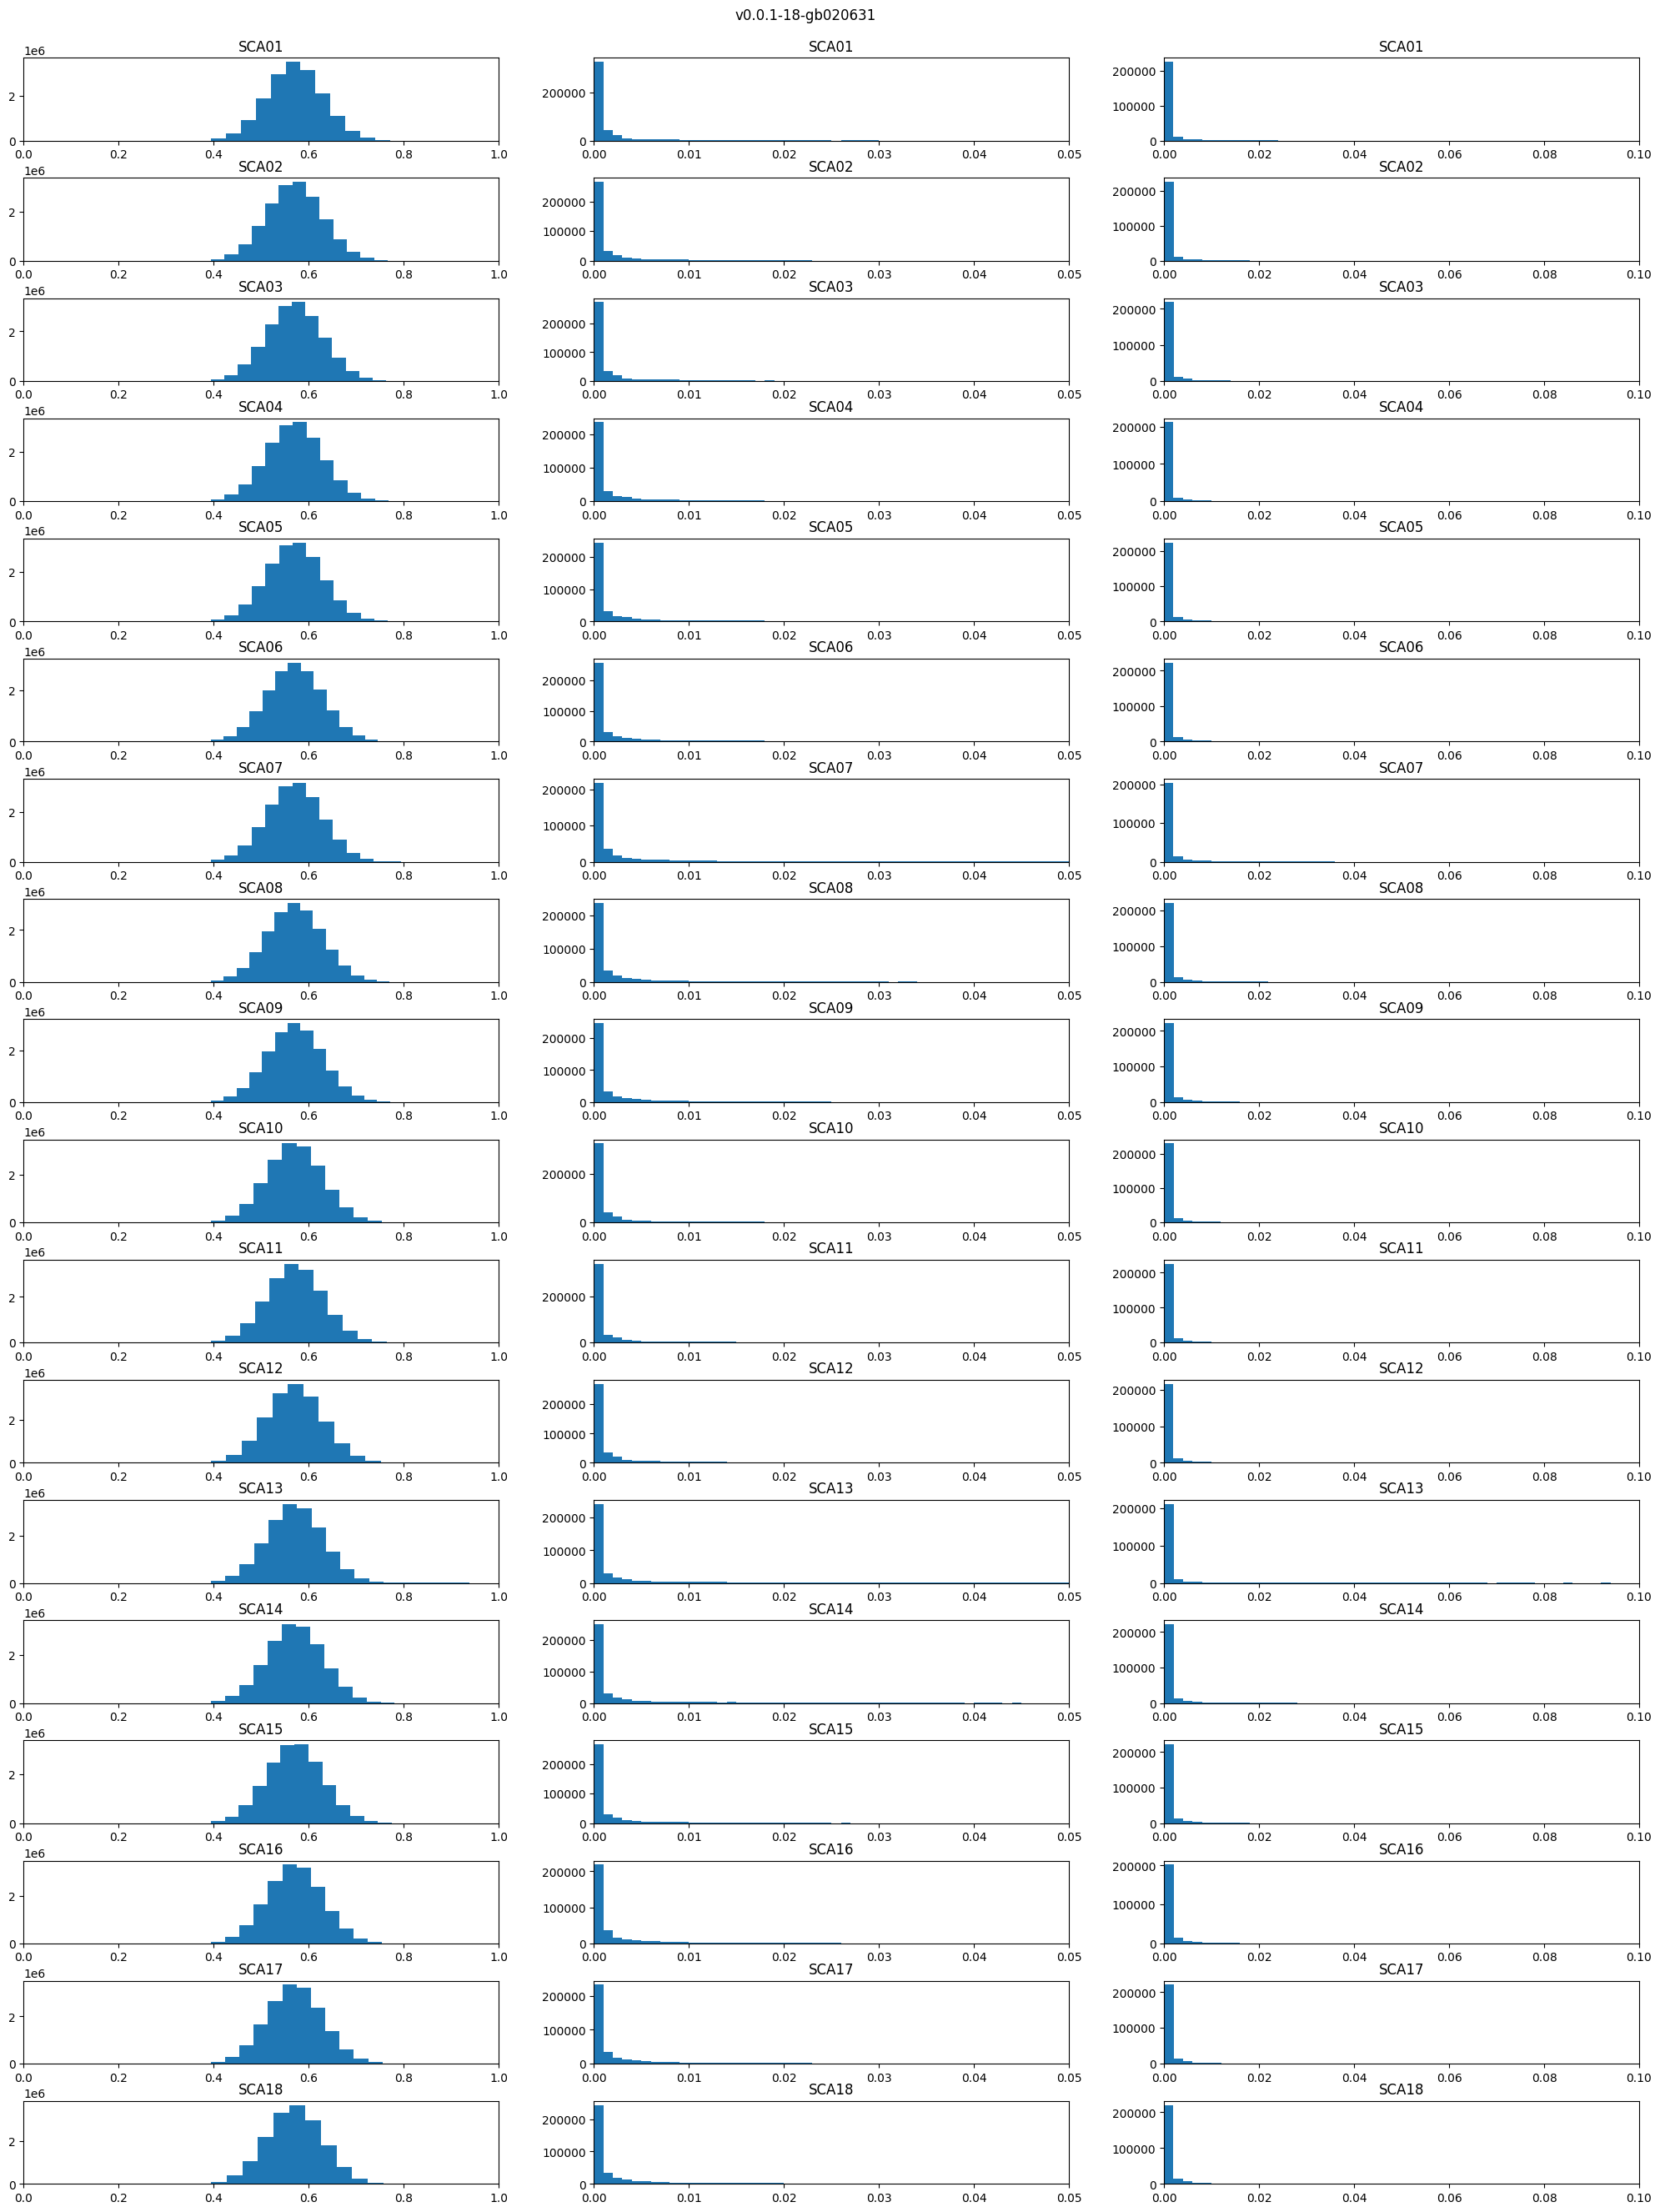

In [44]:
img_list = []

for tag, tag_fns in fn_dict.items():
    fig, ax = plt.subplots(18, 3, figsize=(25, 30))
    fig.suptitle(tag)
    fig.subplots_adjust(top=0.96, hspace=0.45)

    for det, det_fn in tag_fns.items():
        temp_dict = {}
        temp_dict["tag"] = tag
        temp_dict["det"] = det

        ii = int(det[3:]) - 1

        with fits.open(os.path.join(outdir, det_fn["grism"])) as f:
            data = f["SCI"].data.ravel()
            sel = data > 0
            temp_dict["SCI"] = data[sel]
            
            ax[ii][0].hist(data, bins=1000)
            ax[ii][0].set_xlim(0, 1)
            ax[ii][0].set_title(det)

            data = f["model"].data.ravel()
            sel = data > 0
            temp_dict["model"] = data[sel]

            sel &= data < 0.1
            data = data[sel]

            ax[ii][1].hist(data, bins=100)
            ax[ii][1].set_xlim(0, 0.05)
            ax[ii][1].set_title(det)

        with fits.open(os.path.join(outdir, det_fn["refimage"])) as f:
            data = f["IMAGE"].data.ravel()
            sel = data > 0
            temp_dict["IMAGE"] = data[sel]

            sel &= data < 0.2
            data = data[sel]
            
            ax[ii][2].hist(data, bins=100)
            ax[ii][2].set_xlim(0, 0.1)
            ax[ii][2].set_title(det)
        
    img_list.append(temp_dict)
    plt.show()

In [45]:
img_keys = ["SCI", "model", "IMAGE"]

img_tbl = Table(img_list)

for tag in tag_list:
    sel = img_tbl["tag"] == tag
    temp_table = img_tbl[sel]
    print("\033[0;36m" + tag)
    print("-----------" + "\033[0m")
    for key in img_keys:
        data = np.array(temp_table[key][0], dtype=np.float64)
        description = sp.stats.describe(data)

        print(key, "NObs", description.nobs)
        print(key, "min/max", description.minmax)
        print(key, "mean", description.mean)
        print(key, "variance", description.variance)
        print("-----------")

v0.0.1-18-gb020631
-----------
SCI NObs 16711744
SCI min/max (0.3938325047492981, 33.445135727308795)
SCI mean 0.5741320324066569
SCI variance 0.05826398336228711
-----------
model NObs 431096
model min/max (2.386835304055146e-12, 32.15598591300659)
model mean 0.15022661678996702
model variance 2.104554741594839
-----------
IMAGE NObs 264992
IMAGE min/max (1.0085244846198788e-07, 6631.378205949758)
IMAGE mean 0.1574873091016468
IMAGE variance 477.8415013636609
-----------


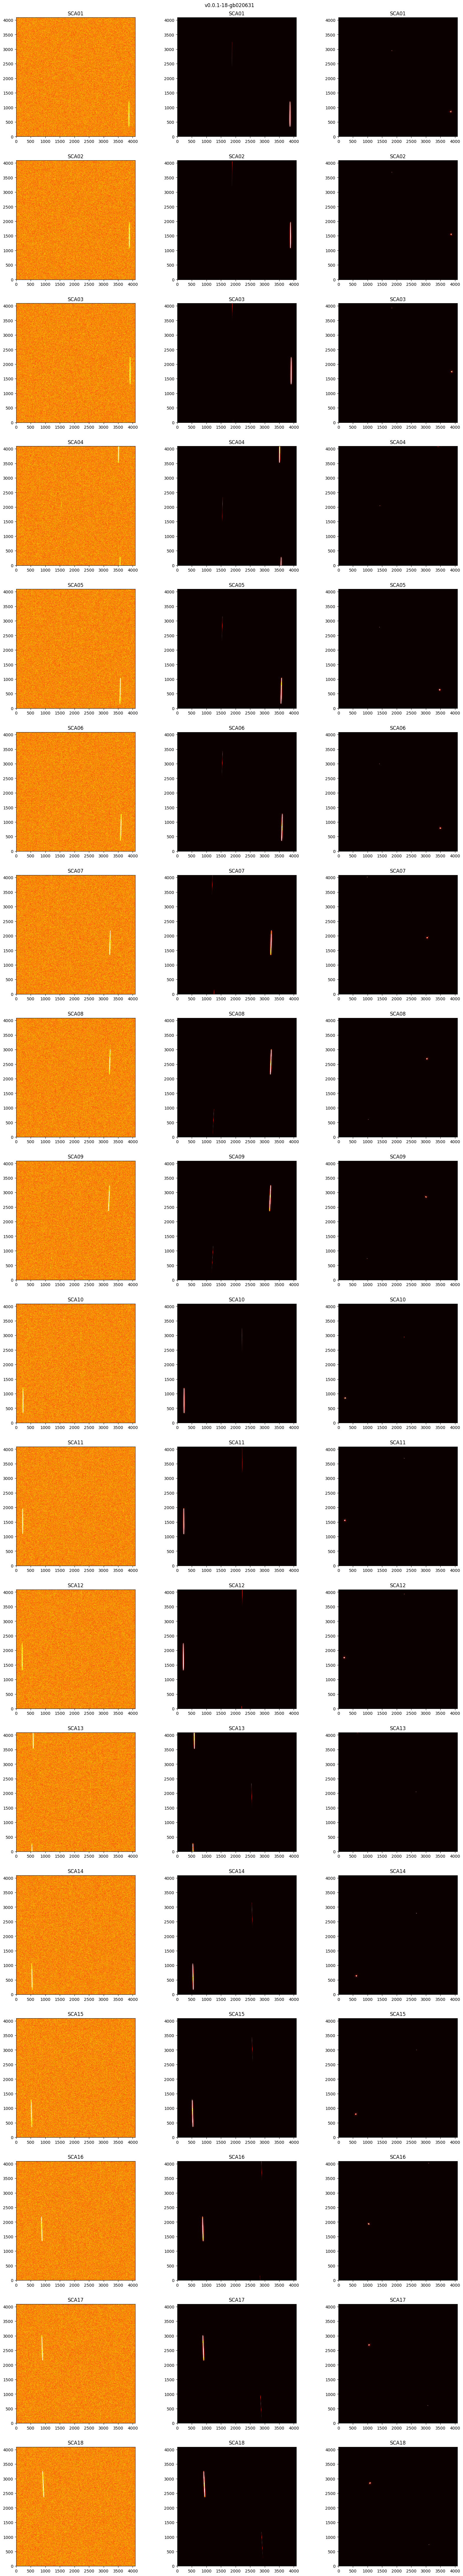

In [46]:
for tag, tag_fns in fn_dict.items():
    fig, ax = plt.subplots(18, 3, figsize=(20, 100))
    fig.suptitle(tag)
    fig.subplots_adjust(top=0.975)

    for det, det_fn in tag_fns.items():

        ii = int(det[3:]) - 1

        with fits.open(os.path.join(outdir, det_fn["grism"])) as f:
            ax[ii][0].imshow(f["SCI"].data, vmin=0, vmax=1)
            ax[ii][0].set_title(det)
            ax[ii][1].imshow(f["model"].data, vmin=0, vmax=0.25)
            ax[ii][1].set_title(det)

        with fits.open(os.path.join(outdir, det_fn["refimage"])) as f:
            ax[ii][2].imshow(f["IMAGE"].data, vmin=0, vmax=1)
            ax[ii][2].set_title(det)

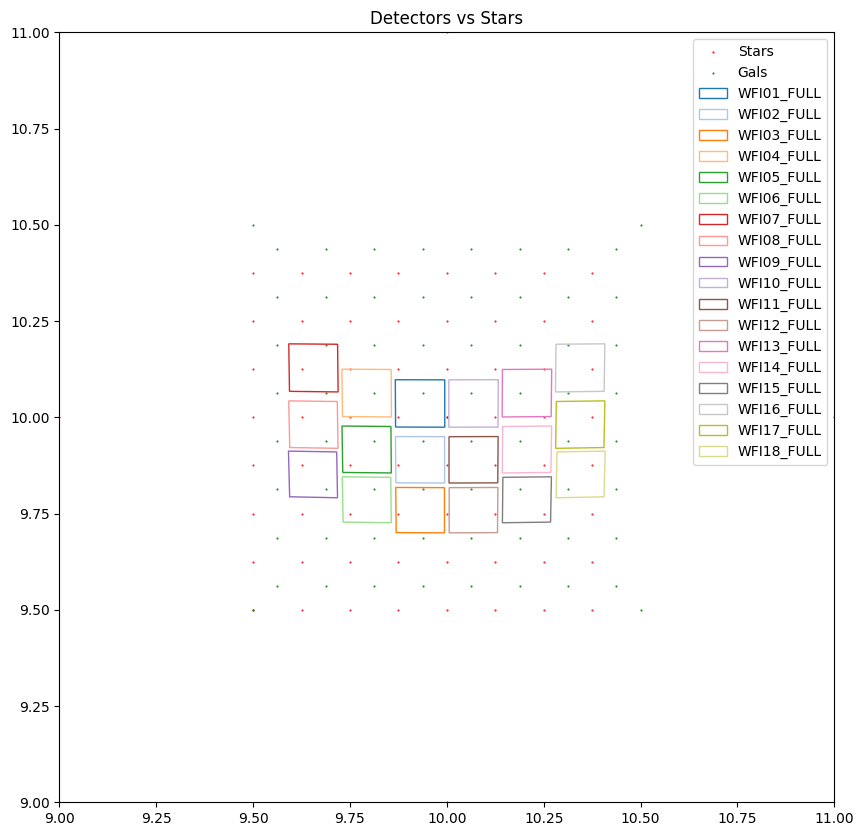

In [47]:
for tag in tag_list:
    display(Image(filename=os.path.join(outdir, f"{tag}_footprint.png")))